In [1]:
# Uncomment the line below to install the matplotlib_scalebar python module.

#!python -m pip install matplotlib_scalebar

# After installing the module, restart the kernel of this notebook 
# and run the cell below. 

In [2]:
# Load the necessary Python packages for the analysis.
%matplotlib inline

import os
import datacube
import pickle
import math
import numpy as np
import geopandas as gpd
import pandas as pd
import xarray as xr
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from IPython.display import Image

from datacube.utils.geometry import Geometry
from datacube.utils.cog import write_cog
from deafrica_tools.plotting import plot_lulc, xr_animation
from deafrica_tools.areaofinterest import define_area
from deafrica_tools.spatial import xr_rasterize
from matplotlib_scalebar.scalebar import ScaleBar 

In [3]:
# Connect to the datacube to access DE Africa data.
# The `app` parameter is a unique name for the analysis which is based on the notebook file name.
dc = datacube.Datacube(app="Landcover_Reclassification")

In [4]:
# Set important parameters for the analysis.

# Set the bands/measurements of the satellite data to load.
measurements = "classification"

# Set the time period of interest for your analysis.
time_range = ("2014", "2019")

# Select the initial and follow up year for the change detection.
initial_year = "2014"
followup_year = "2019"

# Set the x and y cell resolution of the satellite data.
# If loading a large area, then increase the resolution so the data will fit into memory.
resolution = (-300, 300)

# Set the Coordinate Reference System (CRS) the satellite data is to be reprojected to.
output_crs = "EPSG:6933"

# Create the output directory to store the results.
output_dir = "results"
os.makedirs(output_dir, exist_ok=True)

In [5]:
# Load the African Countries GeoJSON.
# This file contains polygons for the boundaries of African countries.
african_countries = define_area(shapefile_path="../Supplementary_data/MGCI/african_countries.geojson")

# List the countries in the African Countries GeoJSON.
countries_list = np.unique([feature["properties"]["COUNTRY"] for feature in african_countries.features])
countries_list

array(['Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso',
       'Burundi', 'Cameroon', 'Cape Verde', 'Central African Republic',
       'Chad', 'Comoros', 'Congo-Brazzaville', 'Cote d`Ivoire',
       'Democratic Republic of Congo', 'Djibouti', 'Egypt',
       'Equatorial Guinea', 'Eritrea', 'Ethiopia', 'Gabon', 'Gambia',
       'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Lesotho', 'Liberia',
       'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Morocco',
       'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda',
       'Sao Tome and Principe', 'Senegal', 'Sierra Leone', 'Somalia',
       'South Africa', 'Sudan', 'Swaziland', 'Tanzania', 'Togo',
       'Tunisia', 'Uganda', 'Western Sahara', 'Zambia', 'Zimbabwe'],
      dtype='<U28')

In [6]:
# Select an African country to carry out the analysis over.
country = "Burkina Faso"

# The country selected needs to be transformed into a geometry object to be used in the dc.load() function.
selected_features = []
for feature in african_countries.features:
    if feature["properties"]["COUNTRY"] == country:
        selected_features.append(feature)
        
country_feature = selected_features[0]
country_geopolygon = Geometry(country_feature["geometry"], crs="EPSG:4326")
country_gdf = gpd.GeoDataFrame(geometry=[country_geopolygon], crs="EPSG:4326").to_crs(output_crs)

In [7]:
# Create a reusable datacube query object.
query = {"geopolygon": country_geopolygon,
         "time": time_range,
         "measurements": measurements,
         "resolution": resolution,
         "output_crs": output_crs}

In [8]:
# Load the ESA Climate Change Initiative Land Cover dataset at 300m resolution.
ds = dc.load(product="cci_landcover", **query)

# Convert the no data values to np.nan.
ds = ds.where(ds != 0)

In [9]:
# Mask the dataset with the country polygon.
mask = xr_rasterize(country_gdf, ds)
ds = ds.where(mask)

In [10]:
# Export the IPCC Land cover dataset for each year as a GeoTIFF.
ds_cci = ds["classification"]

# Loop through each year of the data. 
for i in range(len(ds_cci.time)):
    # Get the data for a single year.
    singleTimestamp = ds_cci.isel(time=i)
    year = singleTimestamp.time.dt.strftime('%Y').data
    # Define the file name for the GeoTIFF.
    fname = f"{output_dir}/{year}_{country.replace(' ', '')}_ipcc_lulc.tif"
    print(f'Writing {fname}')
    # Write the GeoTIFF. 
    write_cog(singleTimestamp, fname=fname, overwrite=True)

Writing results/2014_BurkinaFaso_ipcc_lulc.tif
Writing results/2015_BurkinaFaso_ipcc_lulc.tif
Writing results/2016_BurkinaFaso_ipcc_lulc.tif
Writing results/2017_BurkinaFaso_ipcc_lulc.tif
Writing results/2018_BurkinaFaso_ipcc_lulc.tif
Writing results/2019_BurkinaFaso_ipcc_lulc.tif


In [11]:
# Dictionary to set legend text color in the next cell.
text_font_dict = {
    "no data": "#000000",
    "cropland, rainfed": "#ffff00",
    "cropland, rainfed, herbaceous cover": "#ffff00",
    "cropland, rainfed, tree or shrub cover": "#ffff00",
    "cropland, irrigated or post-flooding": "#ffff00",
    "mosaic cropland/natural vegetation": "#ffff00",
    "mosaic natural vegetation/cropland": "#ffff00",
    "tree cover, broadleaved, evergreen, closed to open": "#054907",
    "tree cover, broadleaved, deciduous, closed to open": "#054907",
    "tree cover, broadleaved, deciduous, closed": "#054907",
    "tree cover, broadleaved, deciduous, open": "#054907",
    "tree cover, needleleaved, evergreen, closed to open": "#054907",
    "tree cover, needleleaved, evergreen, closed": "#054907",
    "tree cover, needleleaved, evergreen, open": "#054907",
    "tree cover, needleleaved, deciduous, closed to open": "#054907",
    "tree cover, needleleaved, deciduous, closed": "#054907",
    "tree cover, needleleaved, deciduous, open": "#054907",
    "tree cover, mixed leaf type": "#054907",
    "mosaic tree and shrub/herbaceous cover": "#054907",
    "mosaic herbaceous cover/tree and shrub": "#ffa500",
    "shrubland": "#ffa500",
    "shrubland, evergreen": "#ffa500",
    "shrubland, deciduous": "#ffa500",
    "grassland": "#ffa500",
    "lichens and mosses": "#ffa500",
    "sparse vegetation": "#ffa500",
    "sparse tree": "#ffa500",
    "sparse shrub": "#ffa500",
    "sparse herbaceous cover": "#ffa500",
    "tree cover, flooded, fresh or brakish water": "#af51ed",
    "tree cover, flooded, saline water": "#af51ed",
    "shrub or herbaceous cover, flooded, fresh/saline/brakish water": "#af51ed",
    "urban areas": "#dc143c",
    "bare areas": "#d6d4b6",
    "consolidated bare areas": "#d6d4b6",
    "unconsolidated bare areas": "#d6d4b6",
    "water bodies": "#069af3",
    "permanent snow and ice": "#d6d4b6",
}

In [12]:
# Define the number of columns in the figure.
ncols = 2 
# Get the number of subplots in the figure.
no_of_subplots = len(ds["classification"].time.values)
# Use the number of columns and the number of subplots to determine the figure length,
# and the figure width.
# For a single subplot width=15 and length=10. 
figure_width = 15 * ncols 
figure_length = 10 * (no_of_subplots/ncols)

# Plot the CCI Landcover dataset.
fig = plot_lulc(ds["classification"], product="CCI", col="time", col_wrap=ncols, figsize=(figure_width, figure_length))
fig.fig.suptitle(f"{time_range[0]} to {time_range[1]} {country} CCI Land Cover ", x=0.4, y=1.02, size=50);

for i, ax in enumerate(fig.axs.flat):
    # Specify the type of notation on the axes of each subplot in the figure.
    ax.ticklabel_format(axis="both", style='scientific', scilimits=(0, 0))
    # Add a scale bar to each subplot in the figure.
    ax.add_artist(ScaleBar(dx=1, location="lower right"))
    # Add the north arrow to the last subplot in the middle row of the figure.
    if i == 3:
        x, y, arrow_length = 1.05, 0.5, 0.2
        ax.annotate('N', xy=(x, y), xytext=(x, y+arrow_length),
                    arrowprops=dict(arrowstyle='<|-, head_length=1, head_width=0.5', facecolor='black'),
                    ha='center', va='center', fontsize=30,
                    xycoords=ax.transAxes)

# Get the colorbar axis from the figure. 
cbar = fig.fig.axes[-1]
# Empty list to store the updated labels.
labels = []
# Get the colorbar labels.
for label in cbar.get_yticklabels():
    # Using the text_font_dict dictionary.
    # Update the label's font color. 
    text = label.get_text()
    text_color = text_font_dict[text]
    label.set_color(text_color)
    # Add the label to the list.
    labels.append(label)

# Update the colorbar's labels.
cbar.set_yticklabels(labels)

plt.savefig(f"{output_dir}/{time_range[0]}_to_{time_range[-1]}_{country.replace(' ', '')}_cci_lulc.png")
plt.show()

In [13]:
# Reclassify the CCI land Cover dataset into seven land use land cover categories.

# Define the labels and class values of the aggregated land use land cover classes.
lulc_labels = ["Treed areas", "Prairies", "Cultivated land", "Wetlands", "Artificial surfaces", "Other land", "Water bodies"]
lulc_classes = [1, 2, 3, 4, 5, 6, 7]
# Map the LULC class labels to the class values.
lulc_class_dict = dict(zip(lulc_classes, lulc_labels))
# Define the colors to be used to represent the aggregated land use land cover categories.
lulc_colors = ["#054907", "#ffa500", "#ffff00", "#af51ed", "#dc143c", "#d6d4b6", "#069af3"]


# Reclassification
treed_areas = [50, 60, 61, 62, 70, 71, 72, 80, 81, 82, 90, 100]
priaries = [110, 120, 121, 122, 130, 140, 150, 151, 152, 153]
cultivated_land = [10, 11, 12, 20, 30, 40]
wetlands = [160, 170, 180]
artificial_surfaces = [190]
other_land = [200, 201, 202, 220]
waterbodies = [210]

reclassification_condition = [ds_cci.isin(treed_areas),
                              ds_cci.isin(priaries),
                              ds_cci.isin(cultivated_land),
                              ds_cci.isin(wetlands),
                              ds_cci.isin(artificial_surfaces),
                              ds_cci.isin(other_land),
                              ds_cci.isin(waterbodies)]

ds_lulc = xr.DataArray(data=np.select(reclassification_condition, lulc_classes),
                       coords={"time": ds.time, "y": ds.y, "x": ds.x},
                       dims=["time", "y", "x"]).astype(ds_cci.dtype).where(mask)

In [14]:
# Export the reclassified land cover dataset for each year as a GeoTIFF.

# Loop through each year of the data. 
for i in range(len(ds_lulc.time)):
    # Get the data for a single year.
    singleTimestamp = ds_lulc.isel(time=i)
    year = singleTimestamp.time.dt.strftime('%Y').data
    # Define the file name for the GeoTIFF.
    fname = f"{output_dir}/{year}_{country.replace(' ', '')}_reclassified_lulc.tif"
    print(f'Writing {fname}')
    # Write the GeoTIFF. 
    write_cog(singleTimestamp, fname=fname, overwrite=True)

Writing results/2014_BurkinaFaso_reclassified_lulc.tif
Writing results/2015_BurkinaFaso_reclassified_lulc.tif
Writing results/2016_BurkinaFaso_reclassified_lulc.tif
Writing results/2017_BurkinaFaso_reclassified_lulc.tif
Writing results/2018_BurkinaFaso_reclassified_lulc.tif
Writing results/2019_BurkinaFaso_reclassified_lulc.tif


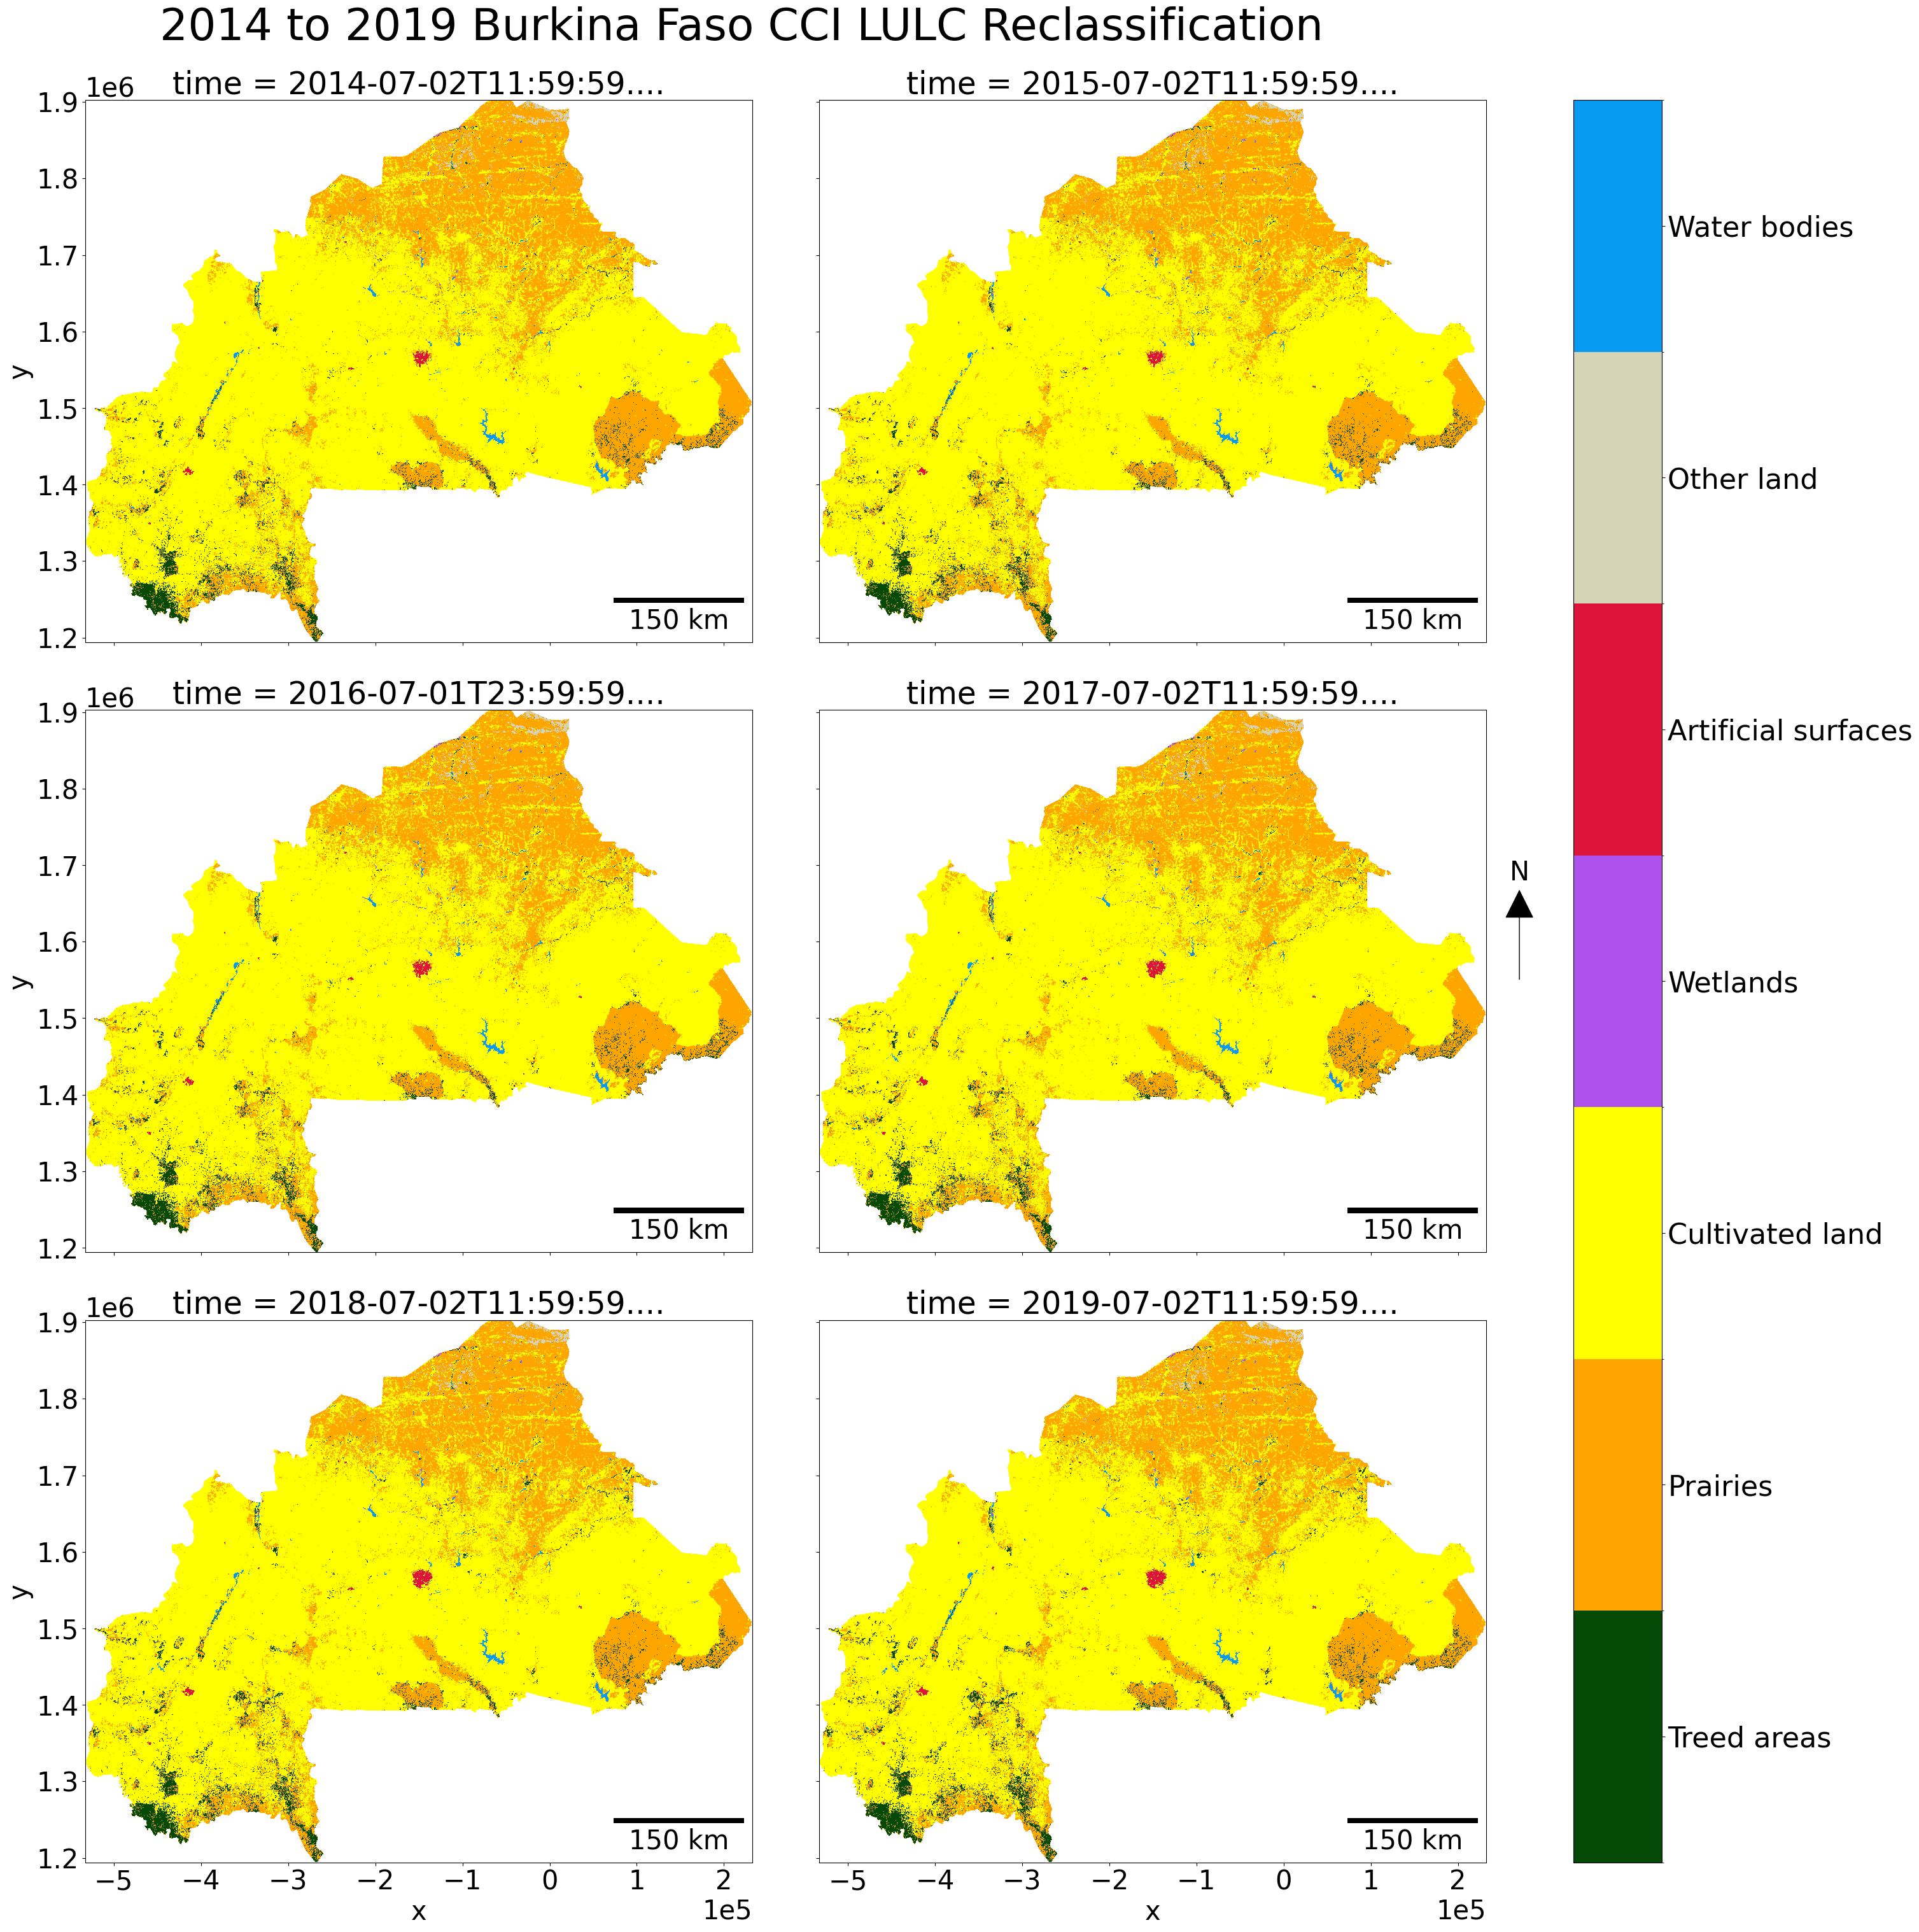

In [15]:
# Set the fontsize to be used for text in the plot.
plt.rcParams.update({'font.size': 30})

# Define the color map to use to plot the reclassified LULC xarray.DataArray.
cmap = mcolors.ListedColormap(colors=lulc_colors, N=len(lulc_classes))
bounds = np.arange(min(lulc_classes) - 0.5, max(lulc_classes) + 1, 1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Visualise the reclassified LULC xarray.DataArray.

# Define the number of columns in the figure.
ncols = 2 
# Get the number of subplots in the figure.
no_of_subplots = len(ds_lulc.time.values)
# Use the number of columns and the number of subplots to determine the figure length,
# and the figure width.
# For a single subplot width=15 and length=10. 
figure_width = 15 * ncols 
figure_length = 10 * (no_of_subplots/ncols)

fig = ds_lulc.plot(col="time", col_wrap=ncols, add_colorbar=False, figsize=(figure_width,figure_length), cmap=cmap, norm=norm)
# Figure title.
fig.fig.suptitle(f"{time_range[0]} to {time_range[1]} {country} CCI LULC Reclassification", x=0.4, y=1.02, size=50)
# Subplots' titles.
fig.set_titles(template='{coord} = {value}', size=35)

for i, ax in enumerate(fig.axs.flat):
    # Specify the type of notation on the axes of each subplot in the figure.
    ax.ticklabel_format(axis="both", style='scientific', scilimits=(0, 0))
    # Add a scale bar to each subplot in the figure.
    ax.add_artist(ScaleBar(dx=1, location="lower right"))
    # Add the north arrow to the last subplot in the middle row of the figure.
    if i == 3:
        # Add a north arrow to the last subplot in the figure. 
        x, y, arrow_length = 1.05, 0.5, 0.2
        ax.annotate('N', xy=(x, y), xytext=(x, y+arrow_length),
                    arrowprops=dict(arrowstyle='<|-, head_length=1, head_width=0.5', facecolor='black'),
                    ha='center', va='center', fontsize=30,
                    xycoords=ax.transAxes)

# Color bar. 
cbar = plt.colorbar(fig._mappables[-1], ax=fig.axs, ticks=lulc_classes)
cbar.set_ticklabels(lulc_labels)
cbar.ax.tick_params(labelsize=32)

plt.savefig(f"{output_dir}/{time_range[0]}_to_{time_range[-1]}_{country.replace(' ', '')}_lulc_reclassification.png")
plt.show()

Exporting animation to results/2014_to_2019_BurkinaFaso_lulc_reclassification.gif


  0%|          | 0/6 (0.0 seconds remaining at ? frames/s)

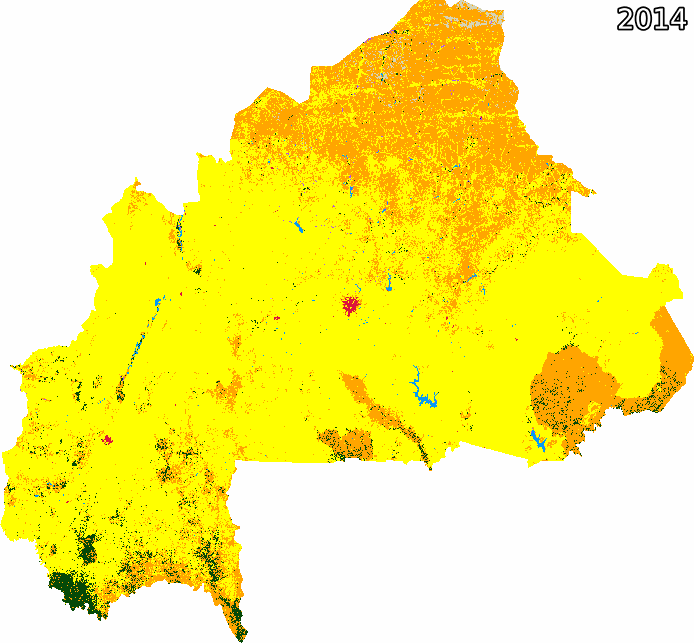

In [16]:
# Produce the reclassified land use land cover time series animation.
xr_animation(ds=ds_lulc.to_dataset(name="LULC"),
             bands="LULC",
             output_path=f"{output_dir}/{time_range[0]}_to_{time_range[-1]}_{country.replace(' ', '')}_lulc_reclassification.gif",
             show_date='%Y',
             interval= 1000,
             percentile_stretch=(0,1),
             imshow_kwargs=dict(cmap=cmap),
             show_colorbar=False)

# Plot the animated GIF.
plt.close()
Image(filename=f"{output_dir}/{time_range[0]}_to_{time_range[-1]}_{country.replace(' ', '')}_lulc_reclassification.gif")

In [17]:
# Get the resolution i.e. actual ground distance represented by the length of a single pixel in meters.
pixel_length = query["resolution"][1]
# Conversion from metres sqaured to hectares.
m2_per_ha = 10000
# Get the actual ground area represented by each pixel.
area_per_pixel = (pixel_length ** 2) / m2_per_ha

In [18]:
# For each year, get the area of each LULC class.

# Empty dictionary to store the loop results.
results = {}

# Group the ds_lulc xarray.DataArray by year.
for year, ds_year in ds_lulc.groupby("time.year"):
    # Convert the xarray.DataArray to a numpy array.
    ds_year_np = ds_year.values
    
    # Use the numpy np.unique function to return the pixel count for each LULC class.
    counts = np.unique(ds_year_np, return_counts=True)
    
    # Remove the counts for np.nan. 
    index = np.argwhere(np.isnan(counts[0]))
    
    # Calculate the area of each LULC class.
    class_labels = [lulc_class_dict[i] for i in np.delete(counts[0], index)]
    class_areas = [int(i*area_per_pixel) for i in np.delete(counts[1], index)]
    
    class_area_dict = dict(zip(class_labels, class_areas))
    
    results[year] = class_area_dict

In [19]:
# Convert the results dictionary into a pandas DataFrame.
results_df = pd.DataFrame.from_dict(results)
results_df.to_csv(f"{output_dir}/{time_range[0]}_to_{time_range[-1]}_{country.replace(' ', '')}_lulc_reclassification_areas.csv")
results_df

,2014,2015,2016,2017,2018,2019
Treed areas,692658,692649,697527,702342,797058,844074
Prairies,6743601,6743520,6726006,6721191,6671151,6605307
Cultivated land,19629801,19628991,19630296,19621431,19568844,19577925
Wetlands,26307,26307,26190,26109,25668,25758
Artificial surfaces,36711,37629,45405,51030,56601,60111
Other land,111033,111015,114165,115038,115326,120717
Water bodies,97128,97128,97650,100098,102591,103347


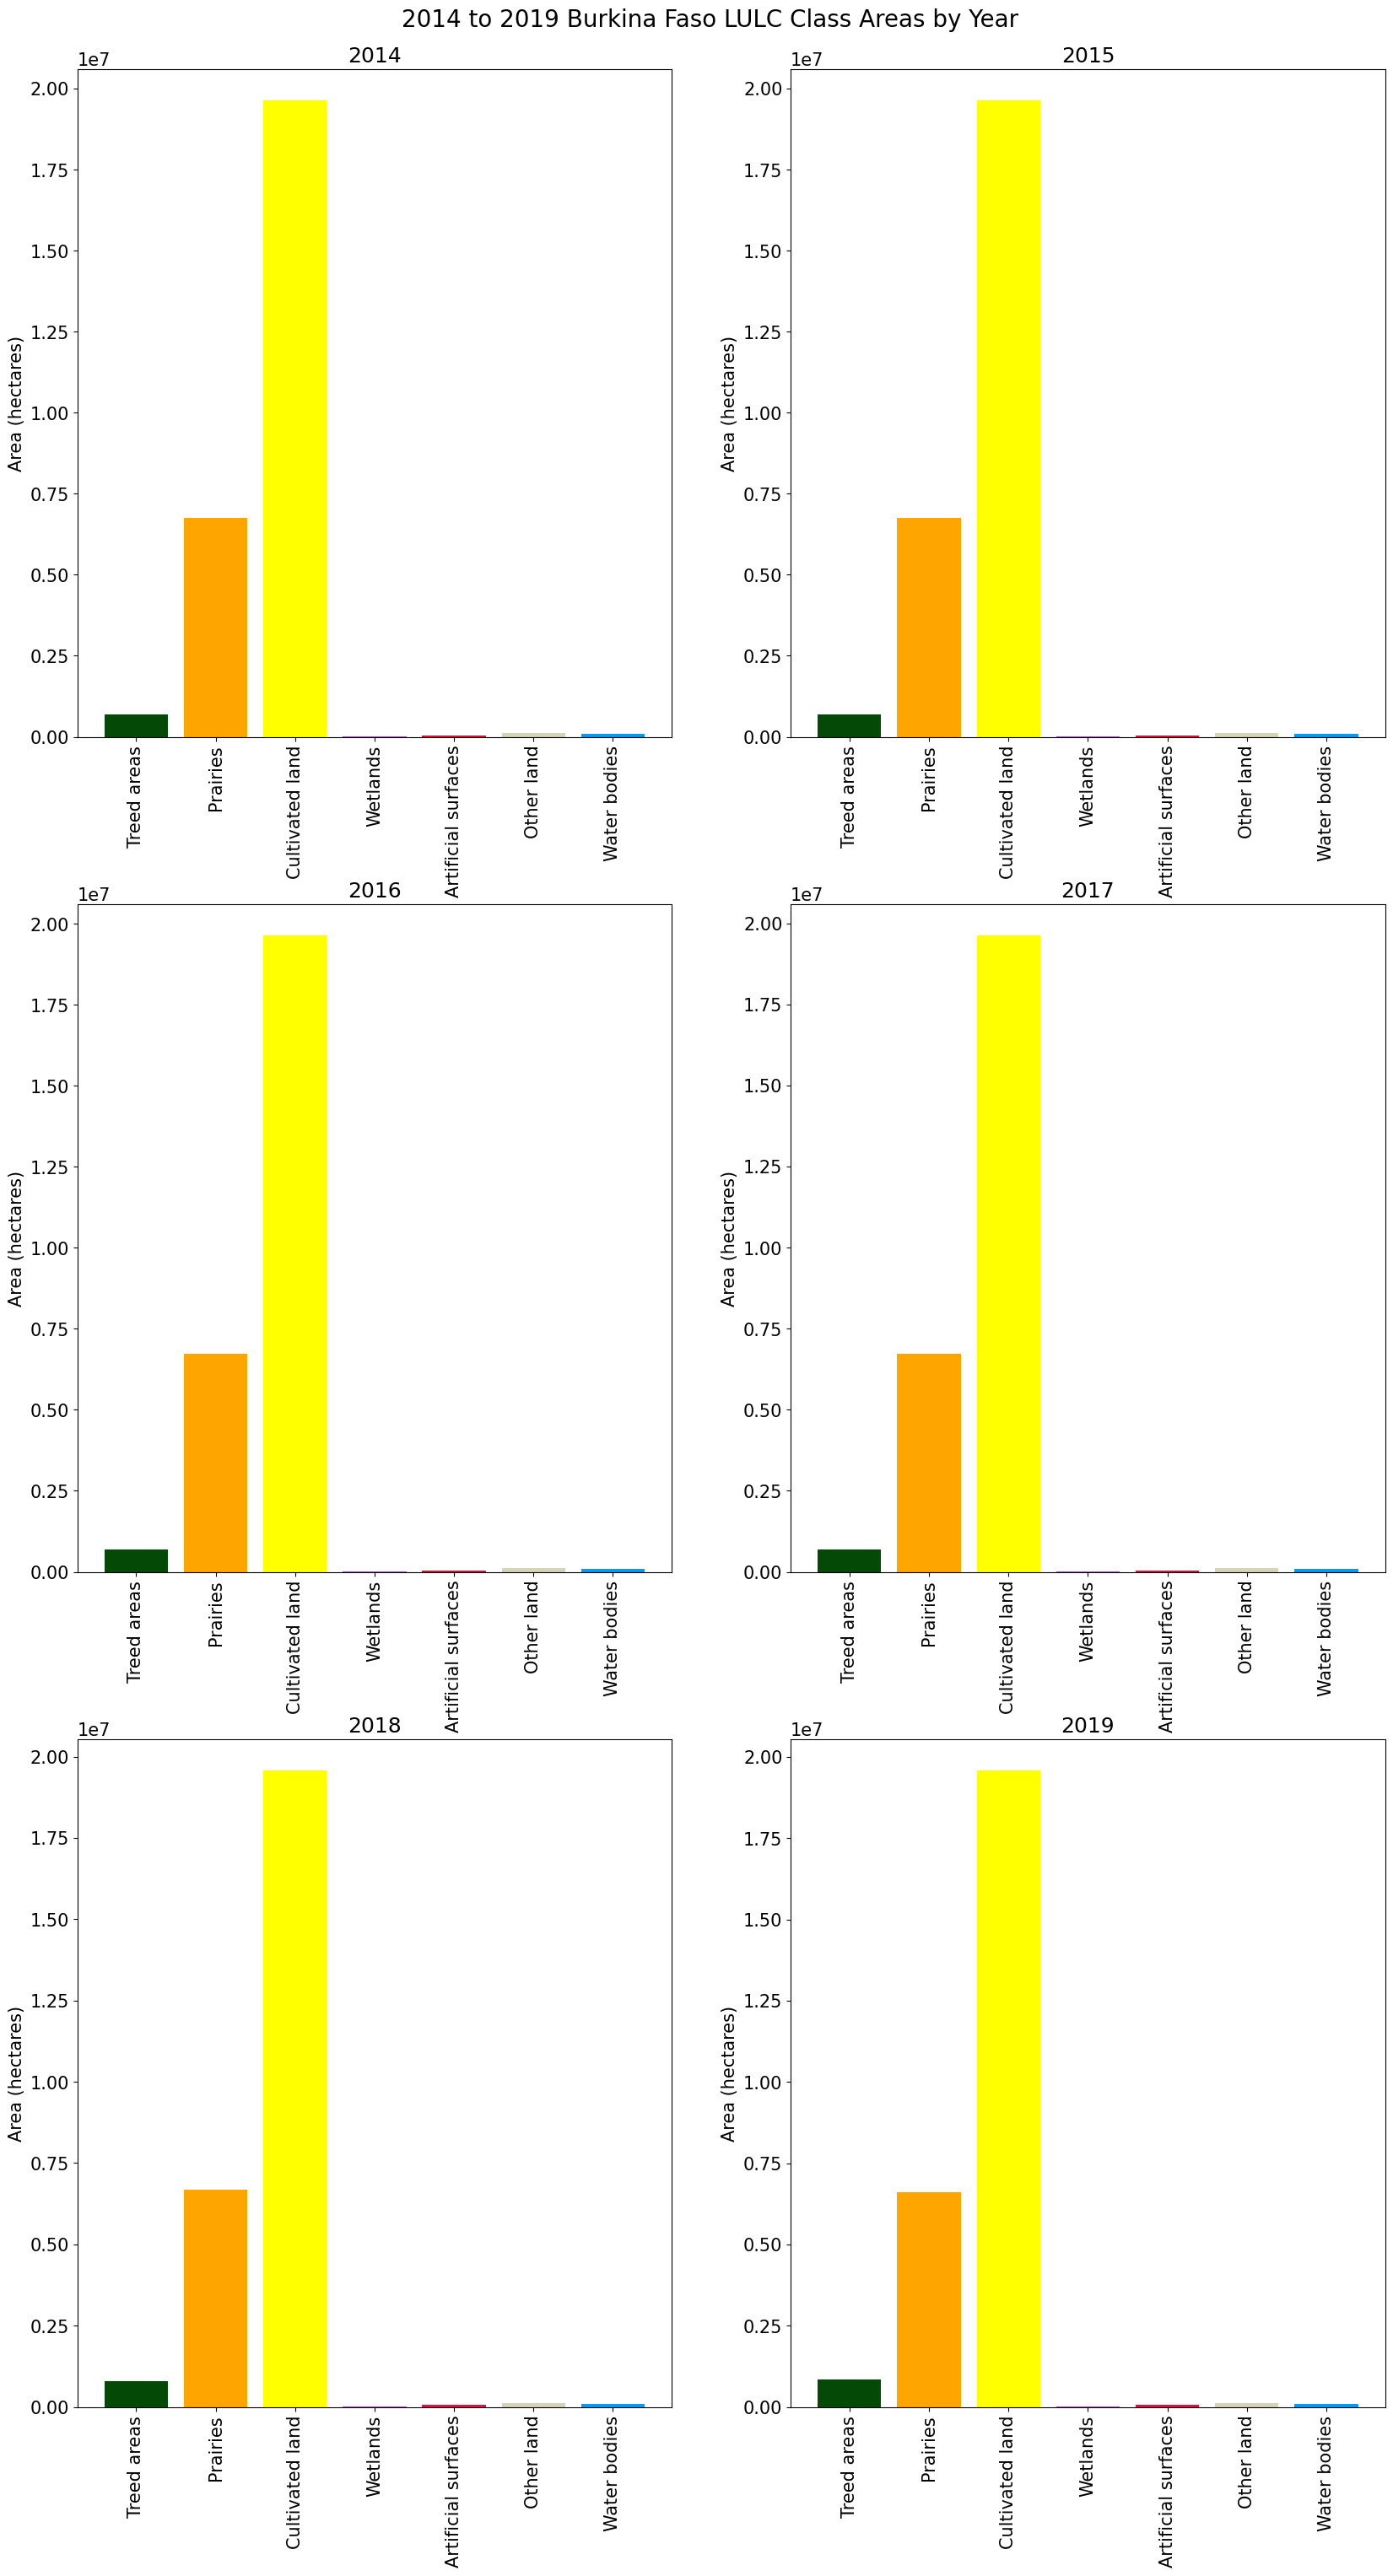

In [20]:
# For each year plot the area for each LULC class. 

# Set the fontsize to be used for text in the plot.
plt.rcParams.update({'font.size': 15})

# Define the subplot grid.
ncols = 2
nrows = math.ceil(len(results_df.columns) / ncols)
# Use the number of subplot rows and columns to determine the figure length,
# and figure width. 
# For a single subplot width=10 and length=12.
figure_width = 10 * ncols
figure_length = 12 * nrows

fig = plt.figure(figsize=(figure_width, figure_length))
plt.subplots_adjust(hspace=0.25)

# Define the figure title.
fig.suptitle(f"{time_range[0]} to {time_range[1]} {country} LULC Class Areas by Year", fontsize=20, y=0.90)

# Loop through each column in the results_df pandas DataFrame.
for i, year in enumerate(results_df.columns):
    subplot = fig.add_subplot(nrows, ncols, i+1)
    # Set the subplot title and fontsize. 
    subplot.set_title(f"{year}", fontsize=18)
    # Set the y axis labels.
    subplot.set_ylabel("Area (hectares)")
    # Plot the column data as a bar graph.
    subplot.bar(x=results_df.index, height=results_df[year], color=lulc_colors )
    # Rotate the xaxis labels.
    subplot.tick_params(axis='x', labelrotation=90)
    # Type of notation on the axes.
    subplot.ticklabel_format(axis="y", style='scientific', scilimits=(0, 0))

plt.savefig(f"{output_dir}/{time_range[0]}_to_{time_range[-1]}_{country.replace(' ', '')}_lulc_class_areas_by_year.png")

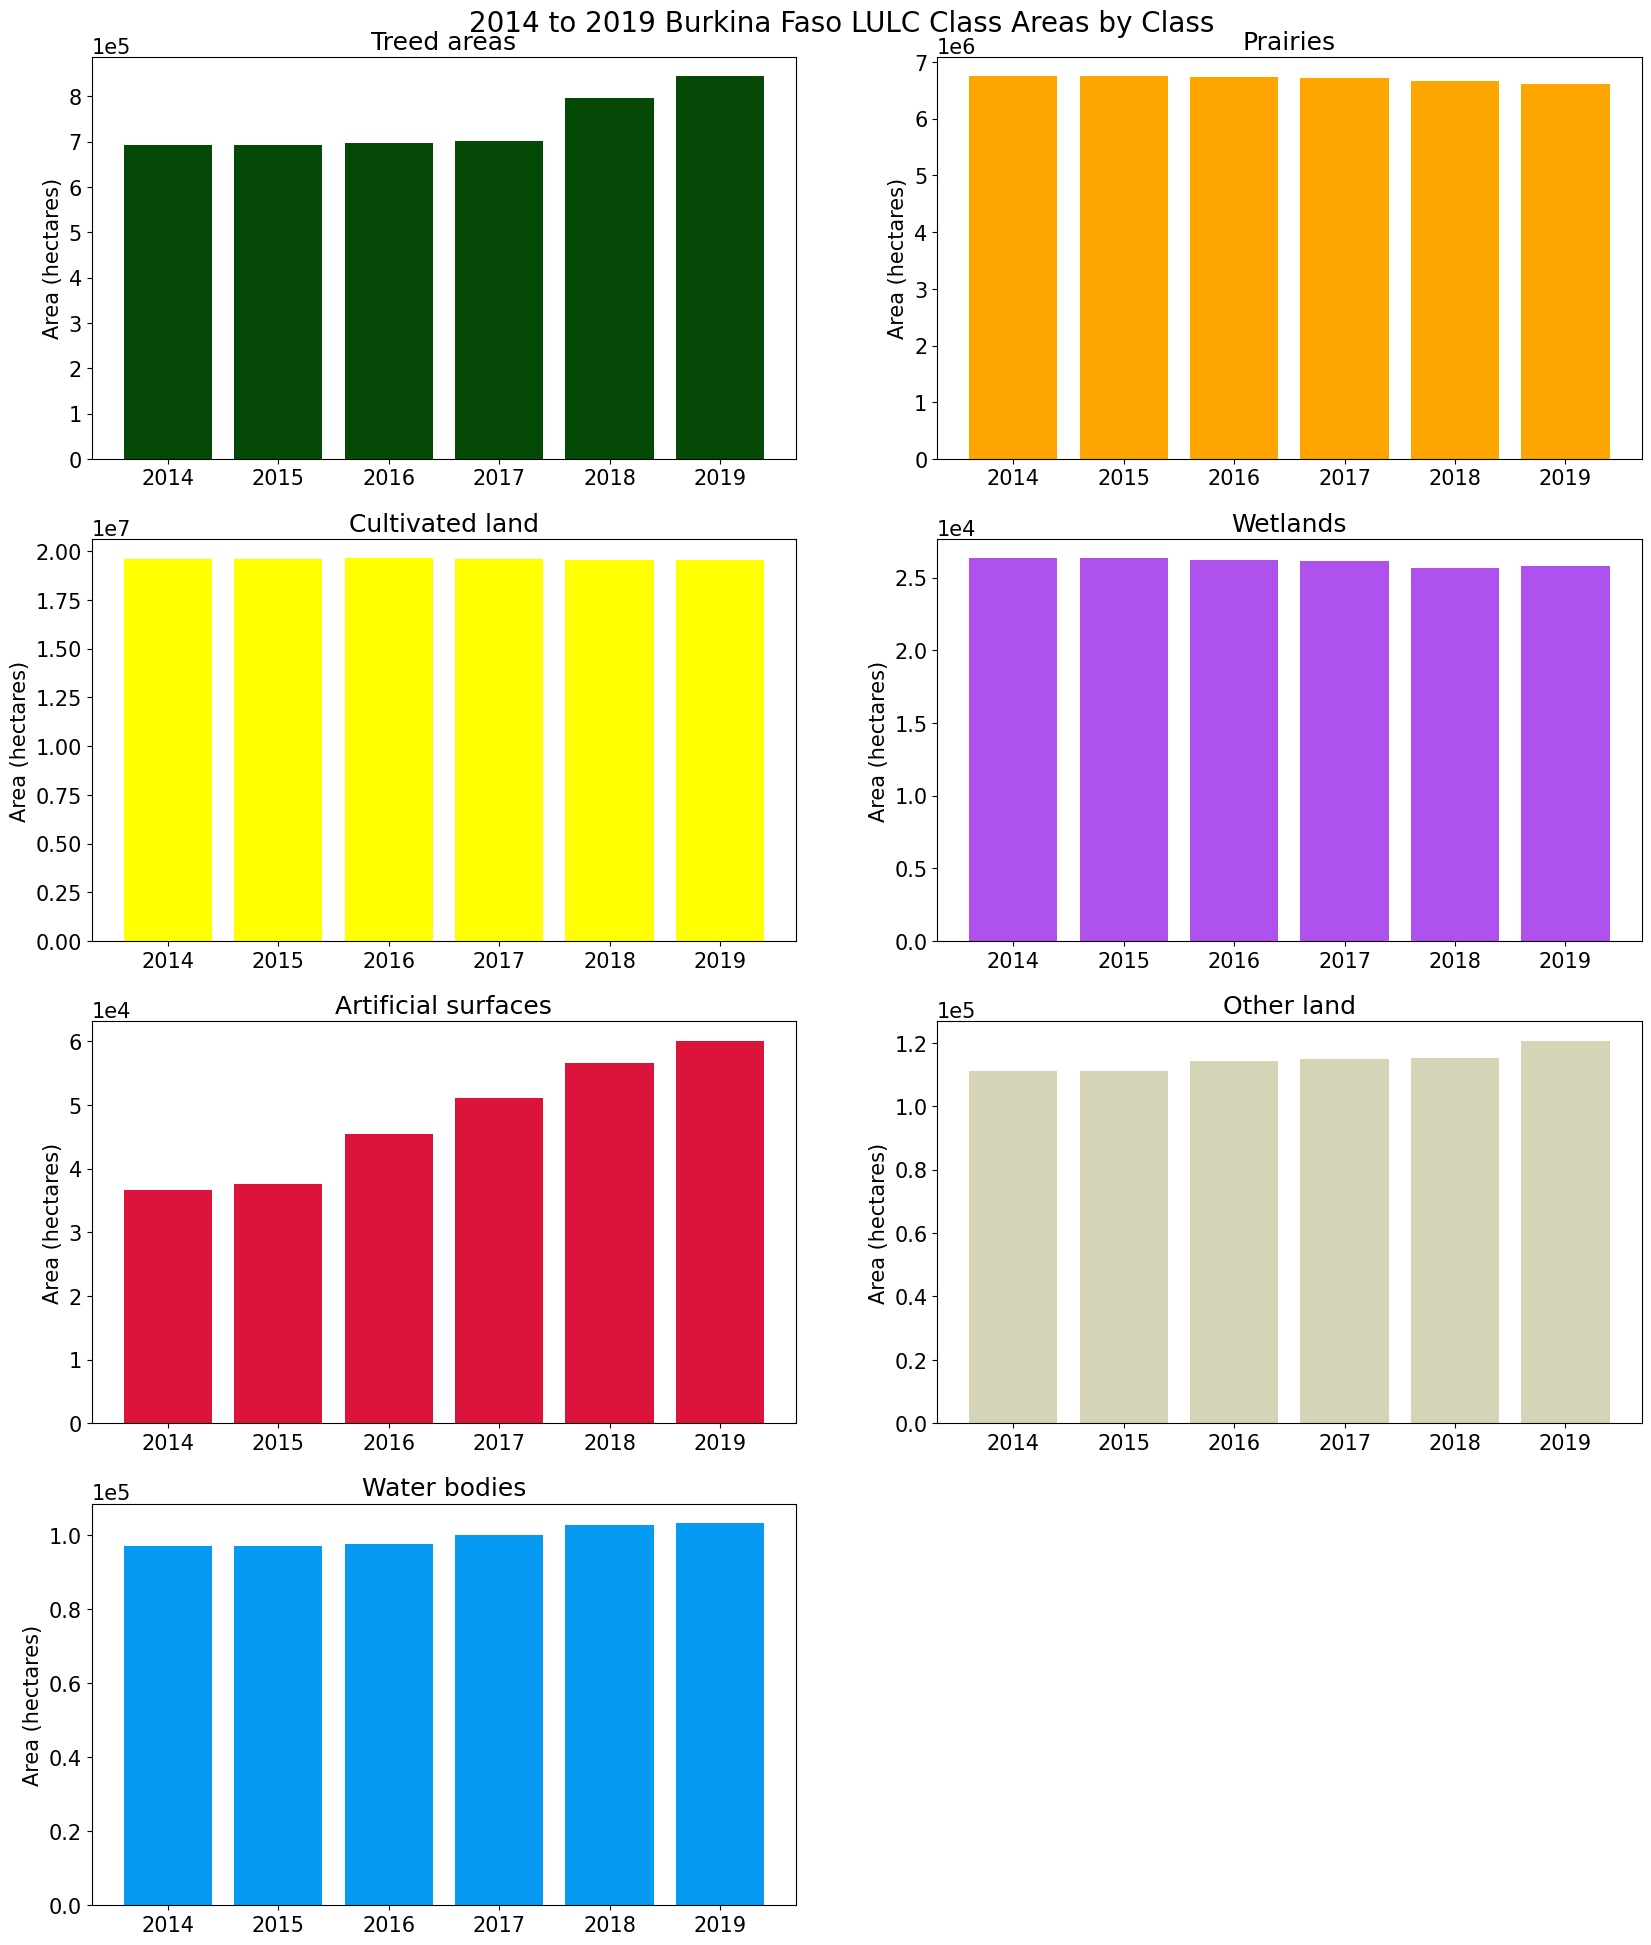

In [21]:
# Plot the area for each LULC class over time.

# Transpose the results_df pandas dataframe.
results_df_1 = results_df.T

# Define the subplot grid.
ncols = 2
nrows = math.ceil(len(results_df_1.columns) / ncols)
# Use the number of subplot rows and columns to determine the figure length,
# and figure width. 
# For a single subplot width=10 and length=6.
figure_width = 10 * ncols
figure_length = 6 * nrows

fig = plt.figure(figsize=(figure_width, figure_length))

# Define the figure title.
fig.suptitle(f"{time_range[0]} to {time_range[1]} {country} LULC Class Areas by Class", fontsize=20, y=0.9)

# Loop through each column in the results_df_1 pandas DataFrame.
for i, lulc_class  in enumerate(results_df_1.columns):
    subplot = fig.add_subplot(nrows, ncols, i+1)
    # Set the subplot title and fontsize. 
    subplot.set_title(f"{lulc_class}", fontsize=18)
    # Set the y axis label.
    subplot.set_ylabel("Area (hectares)")
    # Plot the column data as a bar graph.
    subplot.bar(x=results_df_1.index, height=results_df_1[lulc_class], color=lulc_colors[i])
    # Type of notation on the axes.
    subplot.ticklabel_format(axis="y", style='scientific', scilimits=(0, 0))
    

plt.savefig(f"{output_dir}/{time_range[0]}_to_{time_range[-1]}_{country.replace(' ', '')}_lulc_class_areas_by_class.png")

## Change Detection

In [22]:
# Define the labels and values for the change classes.
change_labels = ["Bad", "Stable", "Excellent"]
change_classes = [-1, 0, 1]
# Define the colors to be used to represent the change classes.
change_colors = [ "red", "orange", "green"]
# Map the change classes to the change labels.
change_class_dict = dict(zip(change_labels, change_classes))

In [23]:
# Select the initial year from which to determine change from.
t0 = ds_lulc.sel(time=initial_year).squeeze().values

# Select the folow up year to use to determine if there was change in a pixel.
tn = ds_lulc.sel(time=followup_year).squeeze().values

In [24]:
# Generate an xarray.DataArray showing where the negative/bad, positive/excellent and stable changes occurred. 

# Define the change numpy array where all changes are assumed to be stable.
change = np.full(shape=t0.shape, fill_value=change_class_dict["Stable"])

# Define the negative/bad changes.
change = np.where((((t0 == 1) & (tn == 2)) | # Treed areas to Prairies
                   ((t0 == 1) & (tn == 3)) | # Treed areas to Cultivated land
                   ((t0 == 1) & (tn == 4)) | # Treed areas to Wetlands
                   ((t0 == 1) & (tn == 5)) | # Treed areas to Artificial surfaces
                   ((t0 == 1) & (tn == 6)) | # Treed areas to Other land
                   ((t0 == 2) & (tn == 3)) | # Prairies to Cultivated land
                   ((t0 == 2) & (tn == 5)) | # Prairies to Artificial Surfaces
                   ((t0 == 2) & (tn == 6)) | # Prairies to Other land
                   ((t0 == 3) & (tn == 5)) | # Cultivated land to Artificial surfaces
                   ((t0 == 3) & (tn == 6)) | # Cultivated land to Other land
                   ((t0 == 4) & (tn == 3)) | # Wetlands to Cultivated land 
                   ((t0 == 4) & (tn == 5)) | # Wetlands to Artificial surfaces
                   ((t0 == 4) & (tn == 6)) | # Wetlands to Other land 
                   ((t0 == 6) & (tn == 5)) # Other land to Artificial surface 
                  ), change_class_dict["Bad"], change)


# Define the positive/excellent changes.
change = np.where((((t0 == 2) & (tn == 1)) | # Prairies to Treed areas
                   ((t0 == 3) & (tn == 1)) | # Cultivated land to Treed areas
                   ((t0 == 3) & (tn == 2)) | # Cultivated land to Priaries
                   ((t0 == 3) & (tn == 4)) | # Cultivated land to Wetlands
                   ((t0 == 4) & (tn == 1)) | # Wetlands to Treed areas
                   ((t0 == 5) & (tn == 1)) | # Artificial surfaces to Treed areas
                   ((t0 == 5) & (tn == 2)) | # Artificial surfaces to Prairies
                   ((t0 == 5) & (tn == 3)) | # Artificial surfaces to Cultivated land 
                   ((t0 == 5) & (tn == 4)) | # Artificial surfaces to Wetlands
                   ((t0 == 5) & (tn == 6)) | # Artificial surfaces to Other land 
                   ((t0 == 6) & (tn == 1)) | # Other land to Treed areas
                   ((t0 == 6) & (tn == 2)) | # Other land to Prairies
                   ((t0 == 6) & (tn == 3)) | # Other land to Cultivated land
                   ((t0 == 6) & (tn == 4)) # Other land to Wetlands
                  ), change_class_dict["Excellent"], change)


# Convert the change numpy array to an xarray.DataArray.
ds_change = xr.DataArray(data=change,
                         coords={"y": ds.y, "x": ds.x},
                         dims=["y", "x"]).astype(ds_cci.dtype).where(mask)

In [25]:
# Export the change xarray.DataArray as a GeoTIFF.
fname = f"{output_dir}/{initial_year}_{followup_year}_{country.replace(' ', '')}_lulc_change_detection.tif"

# Write GeoTIFF. 
write_cog(ds_change, fname=fname, overwrite=True)

PosixPath('results/2014_2019_BurkinaFaso_lulc_change_detection.tif')

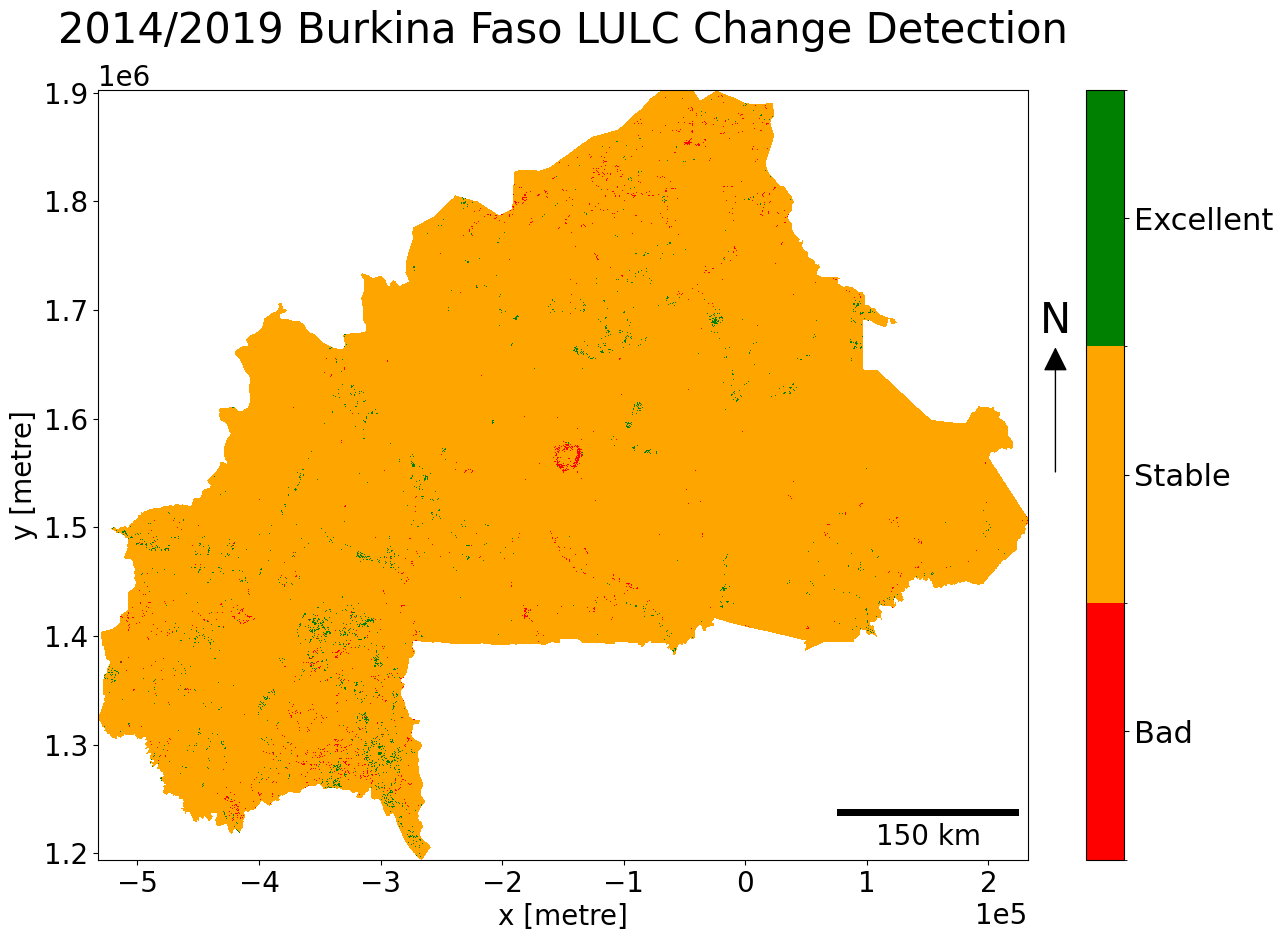

In [26]:
# Set the fontsize to be used for text in the plot.
plt.rcParams.update({'font.size': 20})

# Define the color map to use to plot the change detection xarray.DataArray
cmap = mcolors.ListedColormap(colors=change_colors, N=len(change_classes))
bounds = np.arange(min(change_classes) - 0.5, max(change_classes) + 1, 1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot the change detection xarray.DataArray.
fig , ax = plt.subplots(figsize=(15, 10))
im = ds_change.plot.imshow(add_colorbar=False, ax=ax, cmap=cmap, norm=norm)
# Type of notation on the axes.
ax.ticklabel_format(axis="both", style='scientific', scilimits=(0, 0))
# Add a scale bar.
ax.add_artist(ScaleBar(dx=1, location="lower right"))
# Add a north arrow to the plot. 
x, y, arrow_length = 1.03, 0.5, 0.2
ax.annotate('N', xy=(x, y), xytext=(x, y+arrow_length),
            arrowprops=dict(arrowstyle='<|-, head_length=0.5, head_width=0.25', facecolor='black'),
            ha='center', va='center', fontsize=30,
            xycoords=ax.transAxes)

plt.title(f"{initial_year}/{followup_year} {country} LULC Change Detection", y=1.05, ha="center", size=30)

# Color bar.
cbar = plt.colorbar(im, ticks=change_classes)
cbar.set_ticklabels(change_labels)
cbar.ax.tick_params(labelsize=22)

plt.savefig(f"{output_dir}/{initial_year}_{followup_year}_{country.replace(' ', '')}_lulc_change_detection.png")
plt.show()

In [27]:
# Get the area for each change class.

# Use the numpy np.unique function to return the pixel count for each change class.
counts = np.unique(ds_change, return_counts=True)

# Remove the counts for np.nan. 
index = np.argwhere(np.isnan(counts[0]))

# Calculate the area of each change class.
label_dict = {v: k for k, v in change_class_dict.items()}

class_labels = [label_dict[i] for i in np.delete(counts[0], index)]
class_areas = [int(i*area_per_pixel) for i in np.delete(counts[1], index)]

results = dict(zip(class_labels, class_areas))

# Convert the results dictionary to a pandas DataFrame. 
results_df = pd.DataFrame.from_dict(results, orient='index', columns=["Area (hectares)"])
results_df

,Area (hectares)
Bad,130905
Stable,27009495
Excellent,196839


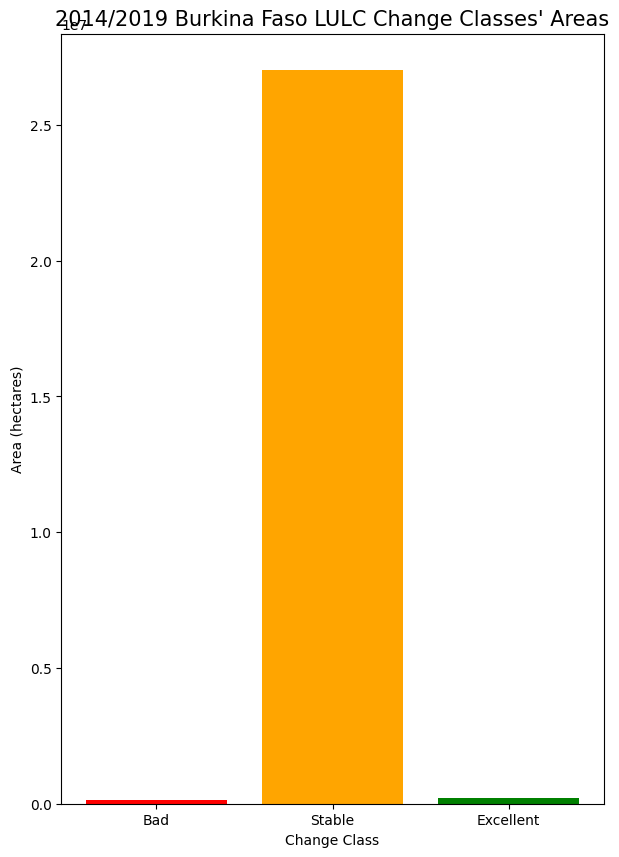

In [28]:
# Set the fontsize to be used for text in the plot.
plt.rcParams.update({'font.size': 10})

fig = plt.figure(figsize=(7, 10))
subplot = fig.add_subplot(1, 1, 1)
subplot.bar(x=results_df.index, height=results_df["Area (hectares)"], color=change_colors )
# Set the x and y axis labels.
subplot.set_xlabel("Change Class")
subplot.set_ylabel("Area (hectares)")
# Set the title. 
subplot.set_title(f"{initial_year}/{followup_year} {country} LULC Change Classes' Areas", y=1.0, size=15)
# Type of notation on the axes.
subplot.ticklabel_format(axis="y", style='scientific', scilimits=(0, 0))

plt.savefig(f"{output_dir}/{initial_year}_{followup_year}_{country.replace(' ', '')}_lulc_change_areas.png");

## Area change matrix

In [29]:
# Styling function to change the background of a cell in a pandas dataframe.  
def lulc_set_background_color(df):

    # Define the background colors to be used for the input dataframe cells.
    # based on the type of LULC class change.
    dont_color = "background-color : white"
    stable = "background-color : orange"
    bad = "background-color : red"
    excellent = "background-color: green"

    # Create a copy of the input dataframe. 
    df1 = df.copy(deep=True)

    # Get the name of the first column.
    first_column = df1.columns[0]
    
    # Define the stable LULC class changes.
    df1.loc[df1.index[df1[first_column] == "Treed areas"], ["Treed areas", "Water bodies"]] = stable
    df1.loc[df1.index[df1[first_column] == "Prairies"], [ "Prairies", "Wetlands", "Water bodies"]] = stable
    df1.loc[df1.index[df1[first_column] == "Cultivated land"], [ "Cultivated land", "Water bodies"]] = stable
    df1.loc[df1.index[df1[first_column] == "Wetlands"], ["Prairies", "Wetlands", "Water bodies"]] = stable
    df1.loc[df1.index[df1[first_column] == "Artificial surfaces"], ["Artificial surfaces", "Water bodies"]] = stable
    df1.loc[df1.index[df1[first_column] == "Other land"], ["Other land", "Water bodies"]] = stable
    df1.loc[df1.index[df1[first_column] == "Water bodies"], ['Treed areas', 'Prairies', 'Cultivated land', 'Wetlands', 'Artificial surfaces', 'Other land', 'Water bodies']] = stable

    # Define the negative/bad LULC class changes.
    df1.loc[df1.index[df1[first_column] == "Treed areas"], ["Prairies", "Cultivated land", "Wetlands","Artificial surfaces", "Other land"]] = bad
    df1.loc[df1.index[df1[first_column] == "Prairies"], ["Cultivated land", "Artificial surfaces", "Other land"]] = bad
    df1.loc[df1.index[df1[first_column] == "Cultivated land"], ["Artificial surfaces", "Other land"]] = bad
    df1.loc[df1.index[df1[first_column] == "Wetlands"], ["Cultivated land", "Artificial surfaces", "Other land"]] = bad
    df1.loc[df1.index[df1[first_column] == "Other land"], "Artificial surfaces"] = bad

    # Define the positive/excellent LULC class changes.
    df1.loc[df1.index[df1[first_column] == "Prairies"], ["Treed areas"]] = excellent
    df1.loc[df1.index[df1[first_column] == "Cultivated land"], ["Treed areas", "Prairies", "Wetlands"]] = excellent
    df1.loc[df1.index[df1[first_column] == "Wetlands"], ["Treed areas"]] = excellent
    df1.loc[df1.index[df1[first_column] == "Artificial surfaces"], [ "Treed areas", "Prairies", "Cultivated land", "Wetlands", "Other land"]] = excellent
    df1.loc[df1.index[df1[first_column] == "Other land"], ["Treed areas", "Prairies", "Cultivated land", "Wetlands"]] = excellent
    
    # Set the background color for the cells in the first column. 
    df1.loc[df1.index, first_column] = dont_color   
    return df1

# Styling function to add a title to a pandas dataframe.
def make_pretty(styler, title):
    # Add a title to the dataframe.
    styler.set_caption(title) 
    # Increase the font size and bold the dataframe title.
    title_style = dict(selector="caption", props=[("font-weight", "bold"), 
                                                  ("font-size", "14px")])
    styler.set_table_styles([title_style])
    return styler

In [30]:
# Generate the reference LULC zone change matrix.
row_labels = lulc_labels
column_labels = lulc_labels

# Create a dataframe where all LULC class changes are classified as stable.
ref_lulc_change_matrix = pd.DataFrame(data="Stable", index=row_labels , columns=column_labels)
# Set the index column name
ref_lulc_change_matrix.index.name = "Year of follow up <br> Initial Year"

# Define the negative/bad LULC class changes.
ref_lulc_change_matrix.loc["Treed areas",["Prairies", "Cultivated land", "Wetlands","Artificial surfaces", "Other land"]] = "Bad"
ref_lulc_change_matrix.loc["Prairies", ["Cultivated land", "Artificial surfaces", "Other land"]] = "Bad"
ref_lulc_change_matrix.loc["Cultivated land", ["Artificial surfaces", "Other land"]] = "Bad"
ref_lulc_change_matrix.loc["Wetlands", ["Cultivated land", "Artificial surfaces", "Other land"]] = "Bad"
ref_lulc_change_matrix.loc["Other land", "Artificial surfaces"] = "Bad"

# Define the positive/excellent LULC class changes.
ref_lulc_change_matrix.loc["Prairies", ["Treed areas"]] = "Excellent"
ref_lulc_change_matrix.loc["Cultivated land",  ["Treed areas", "Prairies", "Wetlands"]] = "Excellent"
ref_lulc_change_matrix.loc["Wetlands",  ["Treed areas"]] = "Excellent"
ref_lulc_change_matrix.loc["Artificial surfaces", [ "Treed areas", "Prairies", "Cultivated land", "Wetlands", "Other land"]] = "Excellent"
ref_lulc_change_matrix.loc["Other land", ["Treed areas", "Prairies", "Cultivated land", "Wetlands"]] = "Excellent"

# Reset the index.
ref_lulc_change_matrix.reset_index(inplace=True)
# Style the dataframe.
ref_lulc_change_matrix = ref_lulc_change_matrix.style.hide(axis="index").apply(lulc_set_background_color, axis=None).pipe(make_pretty, title="LULC Zone Change Matrix")
# Export the ref LULC zone change matrix as a csv file.
ref_lulc_change_matrix.data.to_csv(f"{output_dir}/{country.replace(' ', '')}_reference_lulc_change_matrix.csv", index=False)

In [31]:
display(ref_lulc_change_matrix)

Year of follow up Initial Year,Treed areas,Prairies,Cultivated land,Wetlands,Artificial surfaces,Other land,Water bodies
Treed areas,Stable,Bad,Bad,Bad,Bad,Bad,Stable
Prairies,Excellent,Stable,Bad,Stable,Bad,Bad,Stable
Cultivated land,Excellent,Excellent,Stable,Excellent,Bad,Bad,Stable
Wetlands,Excellent,Stable,Bad,Stable,Bad,Bad,Stable
Artificial surfaces,Excellent,Excellent,Excellent,Excellent,Stable,Excellent,Stable
Other land,Excellent,Excellent,Excellent,Excellent,Bad,Stable,Stable
Water bodies,Stable,Stable,Stable,Stable,Stable,Stable,Stable


In [32]:
# Generate the LULC area change matrix for the selected initial and follow up year.

change_results_per_class = {}
for lulc_class, lulc_class_label in lulc_class_dict.items():
    change_area_dict = {}
    for lulc_change_class, lulc_change_class_label in lulc_class_dict.items():
        # Get area of the pixels where change occured.
        change_area = np.nansum(np.where((t0 == lulc_class) & (tn == lulc_change_class), 1, np.nan)) * area_per_pixel
        change_area_dict[lulc_change_class_label] =  int(change_area)
        
    change_results_per_class[lulc_class_label] = change_area_dict
    
    
# Create a pandas dataframe from the results.    
lulc_change_matrix = pd.DataFrame.from_dict(change_results_per_class)
# Set the index column name.
lulc_change_matrix.index.name = f"{followup_year} <br> {initial_year}"
# Reset the index. 
lulc_change_matrix.reset_index(inplace=True)
# Style the dataframe.
lulc_change_matrix = lulc_change_matrix.style.hide(axis="index").apply(lulc_set_background_color, axis=None).pipe(make_pretty, title=f"{initial_year} to {followup_year} {country} LULC Zone Change Matrix (hectares)")
# Export the LULC zone change matrix as a csv file.
lulc_change_matrix.data.to_csv(f"{output_dir}/{initial_year}_{followup_year}_{country.replace(' ', '')}_lulc_change_matrix.csv", index=False)

In [33]:
display(lulc_change_matrix)

2019 2014,Treed areas,Prairies,Cultivated land,Wetlands,Artificial surfaces,Other land,Water bodies
Treed areas,692469,71865,79479,162,0,99,0
Prairies,18,6560253,41022,0,0,4014,0
Cultivated land,54,93609,19484253,0,0,9,0
Wetlands,0,27,189,25542,0,0,0
Artificial surfaces,90,3861,19404,27,36711,18,0
Other land,0,13725,99,0,0,106893,0
Water bodies,27,261,5355,576,0,0,97128


In [34]:
# Generate the LULC change matrix in percentage for the selected initial and follow up year.
change_results_per_class = {}
for lulc_class, lulc_class_label in lulc_class_dict.items():
    # For each class get the total area in the initial year.
    t0_lulc_class_area = np.nansum(np.where((t0 == lulc_class), 1, np.nan)) * area_per_pixel
    change_area_dict = {}
    for lulc_change_class, lulc_change_class_label in lulc_class_dict.items():
        # Get area of the pixels where change occured.
        change_area = np.nansum(np.where((t0 == lulc_class) & (tn == lulc_change_class), 1, np.nan)) * area_per_pixel
        change_area_percentage = (change_area /  t0_lulc_class_area) * 100
        change_area_dict[lulc_change_class_label] =  format(change_area_percentage, '.2f')
        
    change_results_per_class[lulc_class_label] = change_area_dict
    
# Create a pandas dataframe from the results.    
lulc_change_matrix_2 = pd.DataFrame.from_dict(change_results_per_class)
# Set the index column name.
lulc_change_matrix_2.index.name = f"{followup_year} <br> {initial_year}"
# Reset the index. 
lulc_change_matrix_2.reset_index(inplace=True)
# Style the dataframe.
lulc_change_matrix_2 = lulc_change_matrix_2.style.hide(axis="index").apply(lulc_set_background_color, axis=None).pipe(make_pretty, title=f"{initial_year} to {followup_year} {country} LULC Zone Change Matrix (%)")
# Export the LULC zone change matrix as a csv file.
lulc_change_matrix_2.data.to_csv(f"{output_dir}/{initial_year}_{followup_year}_{country.replace(' ', '')}_lulc_change_matrix_2.csv", index=False)

In [35]:
display(lulc_change_matrix_2)

2019 2014,Treed areas,Prairies,Cultivated land,Wetlands,Artificial surfaces,Other land,Water bodies
Treed areas,99.97,1.07,0.40,0.62,0.00,0.09,0.00
Prairies,0.00,97.28,0.21,0.00,0.00,3.62,0.00
Cultivated land,0.01,1.39,99.26,0.00,0.00,0.01,0.00
Wetlands,0.00,0.00,0.00,97.09,0.00,0.00,0.00
Artificial surfaces,0.01,0.06,0.10,0.10,100.00,0.02,0.00
Other land,0.00,0.20,0.00,0.00,0.00,96.27,0.00
Water bodies,0.00,0.00,0.03,2.19,0.00,0.00,100.00
